# Classification & Logistic Regression
### Moses Marsh


## Morning
- What is classification?
- What is Logistic Regression, and how is it used for classification?
- What are the metrics for evaluating a classifier?
- How is a ROC Curve constructed?

In [20]:
log_model = LogisticRegression()
log_model.fit(X,y)
x_ = np.linspace(40, 160, 100)
log_model.coef_[0]
discriminator_line = -(log_model.intercept_ + log_model.coef_[0][0]*x_)/log_model.coef_[0][1]

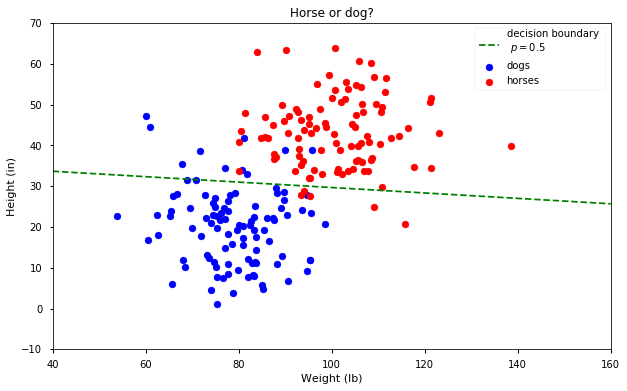

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(X_dogs[:,0], X_dogs[:,1], color='b', label='dogs')
plt.scatter(X_horses[:,0], X_horses[:,1], color='r', label='horses')
plt.plot(x_, discriminator_line, 'g--', label = "decision boundary \n $p=0.5$")
plt.xlim([40,160])
plt.ylim([-10,70])
plt.legend()
plt.xlabel('Weight (lb)')
plt.ylabel('Height (in)')
plt.title('Horse or dog?')
plt.show()


In [23]:
log_model.intercept_

array([-5.16711029])

In [22]:
log_model.coef_

array([[ 0.00946155,  0.14221671]])

In [18]:
xx, yy = np.meshgrid(np.linspace(40,160,300), np.linspace(0,70,300))
xy = np.c_[xx.ravel(), yy.ravel()]
z = log_model.predict_proba(xy)[:,1].reshape(xx.shape)

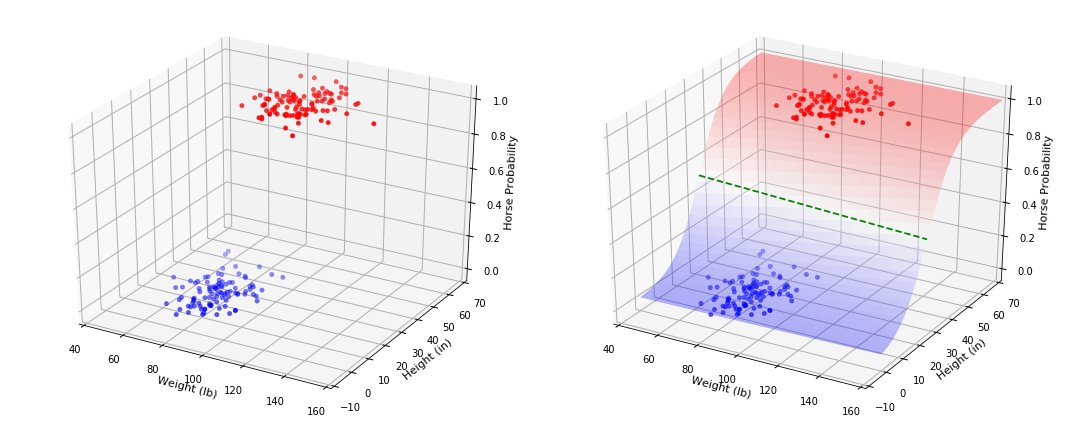

In [19]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c=y, cmap='bwr')
ax.set_xlim([40,160])
ax.set_ylim([-10, 70])
ax.set_xlabel('Weight (lb)')
ax.set_ylabel('Height (in)')
ax.set_zlabel('Horse Probability')
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X[:,0], X[:,1], y, c=y, cmap='bwr')
ax2.plot_surface(xx, yy, z, cmap='bwr', alpha=0.3, rstride=7, cstride=7)
ax2.plot(x_, discriminator_line, zs=0.5, linestyle='--', color='g')
ax2.set_xlim([40,160])
ax2.set_ylim([-10, 70])
ax2.set_xlabel('Weight (lb)')
ax2.set_ylabel('Height (in)')
ax2.set_zlabel('Horse Probability')
plt.tight_layout()

## Choosing a threshold & Evaluating a Classifier

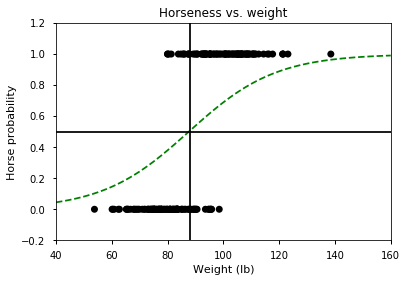

In [20]:
plt.scatter(X[:,0], y, color='k', edgecolor='')
plt.plot(x_, sigmoid, 'g--')
plt.axhline(0.5, color='k')
plt.axvline(88, color='k')

plt.xlim([40,160])
plt.ylim([-0.2,1.201])
plt.xlabel('Weight (lb)')
plt.ylabel('Horse probability')
plt.title('Horseness vs. weight')
plt.show()

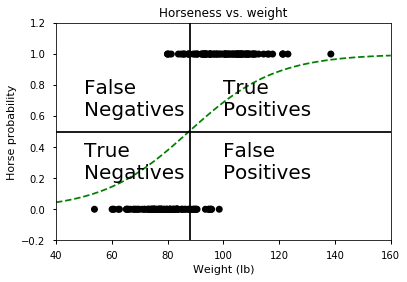

In [18]:
plt.scatter(X[:,0], y, color='k', edgecolor='')
plt.plot(x_, sigmoid, 'g--')
plt.axhline(0.5, color='k')
plt.axvline(88, color='k')

plt.text(50, 0.6, 'False \nNegatives', size=20)
plt.text(50, 0.2, 'True \nNegatives', size=20)
plt.text(100, 0.6, 'True \nPositives', size=20)
plt.text(100, 0.2, 'False \nPositives', size=20)


plt.xlim([40,160])
plt.ylim([-0.2,1.201])
plt.xlabel('Weight (lb)')
plt.ylabel('Horse probability')
plt.title('Horseness vs. weight')
plt.show()

### Confusion matrix

[wiki](https://en.wikipedia.org/wiki/Confusion_matrix)


|                    |Predicted positive|Predicted negative |
|--------------------|------------------|---------------|
| **Actual positive**| # of true positives (TP)    | # of false negatives (FN)|
| **Actual negative**| # of false positives (FP)   | # of true negatives (TN) |


### Classification metrics

n = # of data points

- Accuracy: fraction of data correctly classified
$$\frac{TP + TN}{n}$$
<br />
<br />

- True Positive Rate (aka **Sensitivity**, **Recall**):
fraction of actual positives that were labeled positive
$$\frac{TP}{TP + FN}$$
<br />
<br />

- True Negative Rate (**Specificity**):
fraction of actual negatives that were labeled negative
$$\frac{TN}{TN + FP}$$
<br />
<br />

- **Precision**: fraction of labeled positive points that were actually positive
$$\frac{TP}{TP + FP}$$
<br />
<br />

- False Positive Rate: fraction of actual negatives labeled as positive
$$\frac{FP}{TN + FP}$$
<br />
<br />

- False Negative Rate: fraction of actual positives labeled as negative
$$\frac{FN}{TP + FN}$$
<br />
<br />

- F-Score: a weighted harmonic mean of precision and recall
$$ F = \frac{1}{\alpha\frac{1}{precision} + (1-\alpha)\frac{1}{recall}}$$

- F1-Score ("balanced F-Score") has $\alpha=0.5$
$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$


## Exercise: credit card fraud prediction model

"positive" = "fraud"

"negative" = "not fraud"


|                    |Predicted positive|Predicted negative |
|--------------------|------------------|---------------|
| **Actual positive**| 4   | 10|
| **Actual negative**| 2  | 204 |

- Label each square with one of TP, FP, FN, TN.
- How many total data points do you have? How many are fraudulent? How many aren’t fraudulent?
- Calculate accuracy, precision and recall.


- Is the confusion matrix shown here representative of a good model?
- Which of the metrics you calculated above are most useful in determining how good the model is?
- What are cases where accuracy is useful? When do you need to be wary of using accuracy?


## These metrics change if I change the ***threshold*** for positive classification

e.g., only say “horse!” if the model gave a probability of at least 0.7

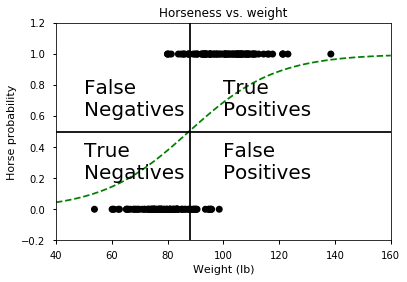

In [19]:
plt.scatter(X[:,0], y, color='k', edgecolor='')
plt.plot(x_, sigmoid, 'g--')
plt.axhline(0.5, color='k')
plt.axvline(88, color='k')

plt.text(50, 0.6, 'False \nNegatives', size=20)
plt.text(50, 0.2, 'True \nNegatives', size=20)
plt.text(100, 0.6, 'True \nPositives', size=20)
plt.text(100, 0.2, 'False \nPositives', size=20)


plt.xlim([40,160])
plt.ylim([-0.2,1.201])
plt.xlabel('Weight (lb)')
plt.ylabel('Horse probability')
plt.title('Horseness vs. weight')
plt.show()

## ROC Curve ("Receiver Operating Characteristic")

A plot of the TPR vs FPR at difference thresholds is called a ROC plot

![](images/roc_curve.png)

fun gif: https://f-origin.hypotheses.org/wp-content/blogs.dir/253/files/2013/09/roc-anim-glm.gif

- If classifier A’s ROC curve is strictly greater than classifier B, then A is preferred
- The AUC (area under curve) is useful for comparing ROC curves.
  - It equals the probability that the model will rank a randomly chosen positive observation higher than a randomly chosen negative observation


## Interpreting ROC curves

If two classifiers have ROC curves that intersect, then the choice depends on the relative importance of sensitivity and specificity

<img src="images/roc_int.png" width="300"></img>

#### Discussion:

When predicting credit card fraud, do we care more about optimizing TPR or FPR?

What is a scenario where our priorities are reversed?

#### Discussion

You have built 3 models to predict whether or not someone will default on a loan. You have 3000 data points and these features: age, gender, city, FICO score, highest education completed

- Which of the 3 ROC curves represents the model you should use?
- How would you pick between 50 models? 100 models? 1000 models?

<img src="images/roc_bad.png" width="500"></img>


#### Exercise

Construct a ROC curve only given the following predicted probabilities from a logistic regression and true labels

```
Predicted Probability | Actual Fraud?
-------------------------------------
    0.99              | Fraud
    0.84              | Fraud
    0.70              | Fraud
    0.70              | Not Fraud
    0.51              | Fraud
    0.22              | Fraud
    0.14              | Not Fraud
    0.05              | Not Fraud

```

# Logistic Regression: Derivation

### Remember linear regression?

There we assumed the data follows the form

$$\begin{align}
Y & = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... \beta_p X_p + \epsilon \\
  & = \mathbf{X} \vec{\beta} + \epsilon
\end{align}$$

where 

$$\epsilon \sim N(0, \sigma)$$

Equivalently, we could write
$$Y \sim N(\mathbf{X} \vec{\beta}, \sigma)$$

From there, we want to find the values for $\vec{\beta}$ that are the most likely to produce the data. We can frame this as a maximum likelihood problem:

$$ L(\vec{\beta}) = f(Y | \vec{\beta}, \mathbf{X}) = \prod_i f(y_i | \vec{\beta}, \mathbf{X}) $$

where $f(y_i | \vec{\beta}, \mathbf{X})$ here is the probability density function for the normal distribution with mean $\mathbf{X} \vec{\beta}$ and variance $\sigma^2$

The values of $\vec{\beta}$ that maximize the likelihood $L$ above turn out to be the same values that minimize sum of squared errors, $\sum_i (y_i - \vec{x_i}\cdot\vec{\beta})^2$

See the proof of this [here](https://www.statlect.com/fundamentals-of-statistics/linear-regression-maximum-likelihood#hid5)

To recap:

Above, we assumed $y \sim N(\mu, \sigma)$, and we assumed $\mu$ was a function of $\vec{x}$. Not just any function, but a linear combination of  $\vec{x}$'s components.
$$ \mu = h(\vec{x}) =  \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots $$

So...

### How can we do the same when $y$ is categorical instead of numerical?

Let's stick with binary classification: $y \in \{0, 1\}$

#### Two values? Sounds Bernoulli enough for me

Let's assume every $y$ is a Bernoulli trial whose probability $p$ depends on $\vec{x}$

$$ y \sim \text{Bernoulli}(p) = \text{Bernoulli}(h(\vec{x}))$$ 

Let's make another assumption: this function $h(\vec{x})$ is a function of a linear combination of $\vec{x}$'s components:
$$ p = h(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots) = h(\vec{\beta}\cdot\vec{x})$$

Now we gotta come up with a function. I'll pull this out of a textbook and see how it behaves.

$$ h(\theta) = \frac{1}{1 + e^{-\theta}} $$

So
$$ p(\vec{x}) = h(\vec{\beta}\cdot\vec{x}) = \frac{1}{1 + e^{-(\vec{\beta}\cdot\vec{x})}} =  \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots)}}  $$


### What does this mean?

For the moment let $\theta = \vec{\beta}\cdot\vec{x} $

Then $$p = h(\theta) = \frac{1}{1 + e^{-\theta}} $$

If we invert this formula, we get
$$ \theta = \text{ln}\left(\frac{p}{1-p}\right)$$

Let's break this down.

What does probability $p$ represent in a Bernoulli trial?

$p \sim \frac{\#successes}{\#trials}$

$p \in [0,1]$

$\frac{p}{1-p}$ has a name: it's the odds. I'll use $d$ to represent odds

$d = \frac{p}{1-p}$ 

$d \sim \frac{\#successes}{\#failures}$

$d \in [0, \infty)$

So now,
$\theta  = \ln(\frac{p}{1-p}) = \ln(d)$

$\theta \in (-\infty, \infty)$

$\theta$ is the **log of the odds**

So the assumption we're making in logistic regression is that ***the log odds are modeled by a linear combination of our features***.

That's our map from feature space to class probabilities.

## Finding the $\beta$ coefficients

Now we can construct a likelihood function

We assume 
$$y \sim Bernoulli(h(\vec{x}\cdot \vec{\beta}))$$

For a Bernoulli trial with success probability $p$, the likelihood is
$$ P(y|p) = p^y(1-p)^{1-y} $$

So for our case, 

$$L(\vec{\beta}) = \prod_i h(\vec{\beta}\cdot \vec{x_i})^{y_i}(1-h(\vec{\beta}\cdot \vec{x_i}))^{1-y_i}$$

Unfortunately, setting the derivative of the likelihood to zero results in a set of nonlinear equations for $\beta_j$ that has no analytical solution. Frowning emoticon.

Tomorrow we'll show how to numerically maximize the likelihood. For computational convenience, we often use the log likelihood

$$\text{log}L(\vec{\beta}) = \sum_i (\, y_i\text{log}(h(\vec{\beta}\cdot \vec{x_i}) + (1 - y_i)(1 - h(\vec{\beta}\cdot \vec{x_i}))\, )$$

## Interpreting the coefficients

#### Let's work in just one dimension, and consider only a one-unit change in $x$

$\theta(x) =\beta_0 + \beta_1x$

$\theta(0) = \beta_0$

$\theta(1) = \beta_0 + \beta_1$

$d(x) = d(\theta(x)) = e^{\theta(x)}$

$d(0) = e^{\theta(0)} = e^{\beta_0}$

$d(1) = e^{\theta(1)} = e^{\beta_0 + \beta_1}$

$\frac{d(1)}{d(0)} = e^{\beta_1}$

#### This is as interpretable as it gets, which is OK! Odds are very intuitive! "the number of successes over the number of failures"

$\beta_1 \rightarrow \infty \Rightarrow p_1 \rightarrow 1$

$\beta_1 = 0 \Rightarrow p_1 = p_0$

$\beta_1 \rightarrow -\infty \Rightarrow p_1 \rightarrow 0$